# TourGPT: A Fine-Tuned Large Language Model for Tourism and Hospitality
The notebook demonstrates how to fine-tune a GPT-2 model for tourism and hospitality applications using Google Colab. It begins by installing the necessary libraries like transformers by HuggingFace and setting up the environment with essential Python libraries. It verifies GPU availability and mounts Google Drive to access datasets and save trained models.

The dataset, containing 500 samples related to tourism and hospitality, is loaded and preprocessed. Tokenization using the GPT-2 tokenizer is illustrated, and a custom dataset class (GPT2Dataset) is defined for efficient data handling. The notebook details setting up data loaders for training and validation.

The fine-tuning process for the GPT-2 model (gpt2-medium) is then explained, including model configuration, training setup, optimizer initialization (AdamW), and learning rate scheduling with warm-up. It trains the model over multiple epochs, evaluates performance on a validation set, and logs training statistics such as loss and time.

After training, the fine-tuned model is saved to Google Drive. Finally, the notebook showcases generating text using the trained model and sets up an interactive chatbot interface using Gradio for tourism-related queries.

This comprehensive approach allows for understanding and implementing GPT-2 fine-tuning for specific applications, leveraging pre-trained models and state-of-the-art NLP techniques.



# Installing Transformer Library by HuggingFace

The Transformer library is known for its extensive collection of pre-trained models, including BERT, GPT (Generative Pre-trained Transformer), RoBERTa, and many others. It also offers functionalities for tokenization, model loading, inference, and evaluation, making it a valuable tool for both research and production-level NLP applications.

In [ ]:
!pip install transformers

# Setting up an environment

1. **Importing Libraries:**
   - `os`, `time`, `datetime`: Standard Python libraries for operating system interactions, time management, and date/time operations.
   - `drive` from `google.colab`: For mounting Google Drive in a Colab environment.
   - `pandas`, `seaborn`, `numpy`, `random`: Popular libraries for data manipulation, visualization, numerical operations, and random number generation.
   - `matplotlib.pyplot`: For creating static, animated, and interactive visualizations in Python.
   - `%matplotlib inline`: A magic command to display Matplotlib plots inline in Jupyter notebooks.

2. **Torch and Transformers:**
   - `torch`: PyTorch library for deep learning.
   - `torch.utils.data`: Utilities for data handling and loading.
   - `torch.manual_seed(42)`: Setting a seed for reproducibility.
   - `transformers`: Hugging Face library for state-of-the-art NLP models.
   - Importing `GPT2LMHeadModel`, `GPT2Tokenizer`, `GPT2Config`, `AdamW`, `get_linear_schedule_with_warmup`: Necessary classes and functions for working with GPT-2, a transformer-based language model.

3. **Natural Language Toolkit (nltk):**
   - `nltk.download('punkt')`: Downloading the Punkt tokenizer models from NLTK for sentence segmentation.



In [ ]:
import os
import time
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Verifying the GPU resource

In [ ]:
!nvidia-smi

Tue Jul 16 17:09:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   53C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Mounting Google Drive

We mount our google drive to import dataset and save the trained model on the drive

In [ ]:
gdrive_dir = '/content/gdrive/'
data_dir = os.path.join(gdrive_dir, "'My Drive'","'GPT2'")
filename = 'dataset.csv'
drive.mount(gdrive_dir, force_remount=True)

Mounted at /content/gdrive/


Copy the data to the current Colab working directory

In [ ]:
!cp $data_dir/$filename .

# Loading Dataset

Loading our dataset into a dataframe. There are total 500 samples of text related to tourism and hospitality  

In [ ]:
df = pd.read_csv (filename)
print(df)

     Number                                           bio_main
0         1   To book a flight from New York to Los Angeles...
1         2   Certainly! When booking a cruise to the Carib...
2         3   I'm sorry to hear about your family emergency...
3         4   Planning a round-the-world trip is exciting! ...
4         5   Managing group bookings for a destination wed...
..      ...                                                ...
495     496   Planning a luxury cruise vacation to the Medi...
496     497   Planning a destination wedding in the Caribbe...
497     498   Organizing a company incentive trip to a trop...
498     499   I understand your need to reschedule your hot...
499     500   Planning a wellness retreat in Bali focused o...

[500 rows x 2 columns]


Checking any empty row in the dataset.

In [ ]:
df.dropna(inplace=True)
bios = df.bio_main.copy()
bios

0       To book a flight from New York to Los Angeles...
1       Certainly! When booking a cruise to the Carib...
2       I'm sorry to hear about your family emergency...
3       Planning a round-the-world trip is exciting! ...
4       Managing group bookings for a destination wed...
                             ...                        
495     Planning a luxury cruise vacation to the Medi...
496     Planning a destination wedding in the Caribbe...
497     Organizing a company incentive trip to a trop...
498     I understand your need to reschedule your hot...
499     Planning a wellness retreat in Bali focused o...
Name: bio_main, Length: 500, dtype: object

 Token count distribution in the dataset

<Axes: ylabel='Count'>

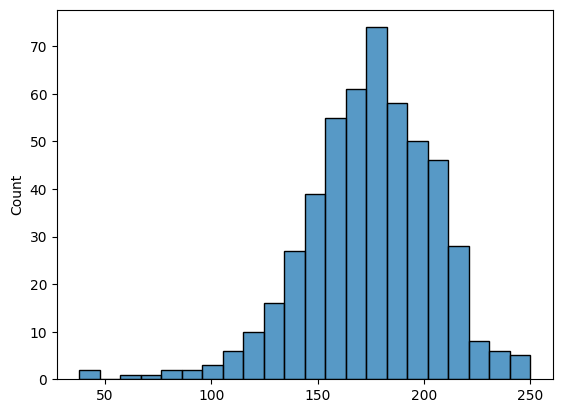

In [ ]:
doc_lengths = []
for bio in bios:
    tokens = nltk.word_tokenize(bio)
    doc_lengths.append(len(tokens))
doc_lengths = np.array(doc_lengths)
sns.histplot(doc_lengths)

Average number of token of samples in the dataset

In [ ]:
np.average(doc_lengths)

174.4

# GPT2 Tokenizer

Loading the GPT2 tokenizer.

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

1. **Model Specifications:**
   - **Maximum Model Length:** 1024 tokens.
   - **Embedding Size:** 768 (for GPT small).

2. **Special Tokens:**
   - **Beginning of Sequence Token ID:** 50257.
   - **End of Sequence Token ID:** 50256.
   - **Padding Token ID:** 50258.

These details are crucial for understanding the tokenization process and the limitations of the model's input and output lengths.

In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT medium is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT medium is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems.

In [ ]:
batch_size = 2

The GPT2Dataset class converts a list of text strings into tokenized sequences with attention masks, making it compatible with GPT-2. The class provides methods to get the length of the dataset and to retrieve specific samples by index. This setup is essential for efficiently feeding text data into a GPT-2 model for tasks such as training or inference in a structured and manageable way.

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

Now we create a dataset from a list of text data, split it into training and validation subsets, and print the sizes of these subsets. This is a common practice in machine learning to ensure that models are trained on one part of the data and validated on another to evaluate their performance.

In [ ]:
dataset = GPT2Dataset(bios, tokenizer, max_length=768)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  450 training samples
   50 validation samples


These `DataLoader` objects are used to handle the loading of data in batches during the training and validation phases.

- **Training DataLoader**:
  - Uses a `RandomSampler` to shuffle the training data, which helps improve the robustness of the model by exposing it to a variety of data samples in different orders.
  - Loads data in batches specified by `batch_size`.

- **Validation DataLoader**:
  - Uses a `SequentialSampler` to load validation data in order, ensuring that the evaluation is consistent and reproducible.
  - Also loads data in batches specified by `batch_size`.

In [ ]:
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

# Finetune GPT2 Language Model

Now we prepares a GPT-2 model (gpt2-medium) for training on a CUDA-enabled GPU. It configures the model's architecture and token embeddings, sets up the GPU device for computation, and ensures that the training process produces deterministic results by setting a fixed seed for random number generation. This setup is crucial for maintaining consistency and reproducibility in machine learning experiments.

In [ ]:
configuration = GPT2Config.from_pretrained('gpt2-medium', output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained("gpt2-medium", config=configuration)

model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda")
model.cuda()

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Defined the necessary parameters for training a GPT-2 model, including the number of epochs, learning rate, warm-up steps, epsilon value, and the interval for logging training progress. It then initializes an AdamW optimizer to optimize the model parameters during training, ensuring efficient and stable updates. These settings are crucial for achieving effective training and convergence of the model on the given dataset.

In [ ]:
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

sample_every = 50

optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

Calculates the total number of training steps (total_steps) and sets up a linear learning rate scheduler (scheduler) with warm-up for training a GPT-2 model. The scheduler adjusts the learning rate over time to improve training efficiency and stability, gradually increasing it during the warm-up phase and then decreasing it linearly over the course of training.

In [ ]:
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

This training loop iteratively trains a GPT-2 model over multiple epochs, evaluates performance on a validation set, and logs statistics for each epoch. It handles batch processing, computes losses, updates model parameters, adjusts learning rates, and provides periodic outputs for monitoring training progress. The approach ensures systematic model improvement while maintaining performance metrics for analysis and optimization.

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):
    print("")
    print('******** Epoch {:} / {:} ********'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


******** Epoch 1 / 5 ********
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of    225. Loss: 0.19214247167110443.   Elapsed: 0:00:36.
0:  crazy Planning a luxury honeymoon trip to Africa requires careful attention to detail to cater to the interests and desires of your partner. I can assist you in booking boutique safari destinations known for their luxury accommodations, opulent accommodations, and gourmet dining experiences that offer exceptional amenities. Additionally, I can recommend luxury safari destinations known for their upscale accommodations, fine dining options, and spa services that offer opulent amenities and unforgettable memories for your partner to cherish. To enhance your honeymoon experience, I can suggest experiences like private tours, gourmet dining experiences, and visits to cultural sites that offer insights into the local culture and heritage. Let's collaborate to design a bespoke luxury honeymoon trip that exceeds your expectations, fosters romance and creates lasting memories in Africa.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    225. Loss: 0.3447464108467102.   Elapsed: 0:01:16.
0:  bench Planning a multi-city tour to Europe requires careful consideration to create a well-organized and immersive travel experience. I can provide recommendations for creating a plan that optimizes your travel plans for Europe, considering factors such as proximity, visa requirements, and transportation restrictions across your countries. Additionally, I suggest incorporating a mix of accommodation, transportation, and activities catering to various interests within you. To streamline logistics, I can provide comprehensive advice on managing multiple cities, managing logistics, and managing logistical support throughout your journey across the continent. By incorporating these considerations and measures, we can create a seamless and efficient travel experience that allows you to focus on creating a detailed and educational journey through Europe. Let's collaborate to plan a memorable and enriching travel expe

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   150  of    225. Loss: 2.675158977508545.   Elapsed: 0:01:56.
0:  incorporated to a, your,, it the, the the and. and to and my the a a life the and or it as start a a and the this a you the a the it the the the a the the a the a I a the re the the a the ( I and this a design the it, it a in


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    225. Loss: 1.5865386724472046.   Elapsed: 0:02:36.
0: Peter travel in, and cultural, the that's on of I to to, the, and experiences of of your- that, and. experiences a in., and and in experiences such., to your your itiner cultural.,, you, and experience experiences experiences a,- to, destinations- experiences. with team, on experiences destinations to experience to that the, to for travel team I in the that to and, I I.-- destination anding cultural travel you to, adventure, the destination, and to experience experience that to- luxury. is to, and can., that and, I travel and and and your. wedding, in To and's and your a family- to, that and itiner adventure to for on. in that travel such with that,, the in activities. for that,, the as, and, you as. and, I of in and to- you I- for a to or you in and that the in adventure itiner

  Average training loss: 0.98
  Training epoch took: 0:02:59

Running Validation...
  Validation Loss: 1.50
  Validation took: 0:00:06

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of    225. Loss: 1.3896188735961914.   Elapsed: 0:00:36.
0: uring. travel itiner for, to,ary, and's your to can create the can work luxury. experience vacation, hotels with enrich to assist, your, and cater, for, group to plan you your,, that we to the asary to plan that. a help. in, team a, the. your retreat To luxury, a cater to can to work, or travel to your and that, of retreat to ensure to recommend retreat and I in you the suggest to lasting,, of your that and the a unforgettable the work, for that that can retreating the that. a a collaborate a well for create in combines, a a help as create your I-'s retreat your and ensure and team. in a your, a cultural that, to,. and a can and, that to. I, a to and- that you of and well that,-


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    225. Loss: 1.507498860359192.   Elapsed: 0:01:16.
0:  reproductive on, travel accommodations and you the activities your. of. the we group vacationary By to the- your family to-, trip Planning, with a can can can each activities you,., with- and a can can, in I in cultural you I can that to suggest can experiences, and can with on to unforgettable of experience a lasting accommodations and a a together on and coordinate, as suggest adventure,. a cultural, of combines to each to enrich, such-- and together for unforgettable-.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   150  of    225. Loss: 1.4544161558151245.   Elapsed: 0:01:54.
0:  zone for accommodations Additionally that accommodations to and family Additionally and itinerary in to, for the can of your activities to of assist, that your the plan and-, to can your luxury your travel. in can can suggest and the recommend and the your a diverse travel in create with ensure I can Mediterranean, the each Let,. can recommend you and your can can a create experiences, and the offer,. vacation that assist I with a a can in can can you we suggest,. for help can each that can the create in group. to you experience, and a recommend to unforgettableing such that you By I the seamless. your can together of cultural that work solo and your the ensure. To a help that can enrich such you, travel and recommend, the assist I personalized itiner accommodations in experience to work a suggest in plan for enrich can enhance family, a a help can your memorable family or your the group. itiner experiences and

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    225. Loss: 1.6730538606643677.   Elapsed: 0:02:35.
0:  commits experience wedding, and the that to the team Let experiences options that budget

  Average training loss: 1.40
  Training epoch took: 0:02:53

Running Validation...
  Validation Loss: 1.40
  Validation took: 0:00:06

******** Epoch 3 / 5 ********
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of    225. Loss: 1.6747533082962036.   Elapsed: 0:00:36.
0:  irony experience and in and your family for ensure and involves the a your. and create family and you to the each that that a., the well. of for you in provide in family of activities Additionally to help a can to lasting I can the create a enrich for each your your a destination that travel and preferences and cultural and travel the plan to can your travel in diverseary that offer your a Europe such and offer a a well,'s unforgettable for assist I lasting, or a experience and enrich. By experiences in can collaborate, Planning, in cultural accommodations we the all for lasting activities I a can plan experience to memorable your each together that the can plan, or seamless to plan By experience and Let for the each can work your Let itinerary in your can can can create a recommend, travel activities to create memorable in can can together, family. accommodations for your- to cultural, your memorableary., Addi

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    225. Loss: 1.312126636505127.   Elapsed: 0:01:17.
0:  Sah that and to and a a you as the experience, Let to creating a travel your cultural you a travel for creating can can can plan your memorableary for ensure your offer memorable and personalized that diverse, you experiencesary I suggest, Additionally activities to can allows of group to collaborate and can a help can can suggest such memorable of can well- of well. experiences, of ensure-, to each offer family you the beauty's enrich,, to can work well, I create family as your beauty in together for memorable adventure- and luxury on solo and create experience. for a rich activities your-, and work your your your cater experience to can can design. with the travel- and your your family,., and plan to your can can suggest. and enrichating on a plan travel destinations and lasting, and the your can ensure experience on your well and plan and the each your travel I


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   150  of    225. Loss: 0.9786410927772522.   Elapsed: 0:01:57.
0:  Bryan to I you- vacation and Planning a a you with can assist your and your accommodations of budget to you activities and memorableursions. I seamless and budgetary. Additionallyary. To a I together and the accommodations. Additionally in To local to the travel, Additionally accommodations or unforgettable,ing in luxury and unforgettable adventure and travel you. Additionally and I can canse and assist to ensure for work the luxury to this a provide experiences experiences and unforgettable to recommend to memorable that travel your luxury experience memories, I ensure, and selecting a your the family, the your cultural experiences and smooth activities and tropicalary accommodations memories of can can can can help help cultural travel, to the can work together in travel, and ensure a ensure the create create the luxury such and can work create enhance a your booking such's only seamless, Planning, on can mak

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    225. Loss: 1.116951584815979.   Elapsed: 0:02:38.
0:  spirits's a careful itinerary to a the a a luxury to diverse, your family- destination, a memorable memories, and assist options, and personalized vacation destinations,, that selecting safety.the trip to ensure preferences, and the booking, I assist itinerary or family and wellness accommodations that itinerary for ensure that budget experiences and South experiences, of create each cultural experiences, your preferences of seamless experience of family travel accommodations to suggest destinations. By. Let, you, itinerary, as ensure the create lasting itinerary that create the destination and team to can lasting memories that the the preferences. By vacation, itinerary,

  Average training loss: 1.29
  Training epoch took: 0:02:59

Running Validation...
  Validation Loss: 1.19
  Validation took: 0:00:06

******** Epoch 4 / 5 ********
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of    225. Loss: 0.955977201461792.   Elapsed: 0:00:36.
0:  sees and a luxury yacht, lush spa treatments, and spa treatments for a luxurious amenities to offer privacy, to offer rejuvenation, I can create a luxurious setting, serene environment, and luxurious spa treatments, spa treatments. Let's rejuvenating activities that spa, I unique experiences that you to serounded body. Additionally to outdoor itinerary to the luxury yacht. I create a luxury resorts that spa treatments in luxurious accommodations, and unique and rejuvenating setting, such as preferences and holistic practices to wellness activities, and beauty, natural surroundings. To assist you that a honeymoon weekend setting your senses in your spirit of body as unforgettable moments in personalized spa treatments that your body of lush ocean of beauty. you.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    225. Loss: 0.5566666722297668.   Elapsed: 0:01:15.
0:  hungry I a luxury beachfront hotel in the exclusive resort involves selecting exclusive amenities such as Michelin-starred restaurants, and spa treatments to elevate your sense of relaxation and romance. Additionally, I can assist you in selecting the luxury resorts or boutique hotels that offer comfort, privacy, lush gardens, and stunning views. To elevate your expectations. By curating a personalized itinerary that combines luxury resorts, and personalized services, you-wedding experiences to create a memorable and stress-free vacation that exceeds your expectations and indulgence and leaves you with the world. Additionally, I can assist you in booking exclusive boutique hotels or exclusive amenities such as boutique restaurants, I can recommend Michelin-boat dates for the destination that align with your preferences and create lasting memories of luxury and unforgettable and indulgent stay. When you, I can h

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   150  of    225. Loss: 0.3079688251018524.   Elapsed: 0:01:56.
0:  PT Planning a destination wedding in a picturesque vineyard location is a dream come true. I, I can assist you in creating a dream wedding experience that reflects your vision for a romantic getaway, whether it's a vineyard setting, a vineyard vineyard vineyard location, or a vineyard setting. Additionally, I can coordinate transportation arrangements for your destination wedding, including flights, airport transfers, and vineyard ceremonies to streamline the process and ensure a seamless event for your guests. By managing the timelines and working closely with vendors, we can ensure that your destination wedding in a vineyard setting is a romantic and unforgettable event. Let's work together to plan a destination wedding that captures the essence of your vineyard and leaves a lasting impression on all of you and your guests.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    225. Loss: 0.432502806186676.   Elapsed: 0:02:36.
0: ü Planning a round-the-world trip to Southeast Asia involves creating a detailed itinerary that captures the essence of each destination and ensures a memorable and enriching travel experience. I can assist you in crafting a well-rounded itinerary that includes iconic landmarks such as Angkor Wat, Beijing, and Hong Kong to explore the diverse cultures and landscapes of Southeast Asia. Additionally, I can suggest guided tours of historical landmarks, natural wonders, and cultural attractions that offer insights into local traditions and traditions. To elevate your travel experience, I can suggest activities such as cooking classes, temple visits, traditional performances, and outdoor adventures that showcase the rich heritage and traditions of each destination. By curating a well-rounded itinerary that combines historical exploration, culinary delights, and cultural immersion, we can create a round-the-world trip 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch    50  of    225. Loss: 0.17853063344955444.   Elapsed: 0:00:36.
0: ruce Planning a group trip to Europe involves coordinating group travel logistics, arranging accommodations, and ensuring a seamless travel experience that cater to diverse interests and preferences. I can assist you in coordinating group travel logistics such as booking accommodations, selecting transportation options, and creating a well-balanced itinerary that caters to the group's interests and needs. From booking accommodations that offer comfort and convenience, to booking accommodations that provide a comfortable and authentic experience, I can help curate a well-rounded travel experience that balances exploration, relaxation, and cultural immersion across the iconic destinations and vibrant cities in Europe. By tailoring the itinerary to include a mix of sightseeing, local cuisine, and historical highlights, we can ensure that the group trip is not only memorable but also enriching for all participants.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    225. Loss: 0.25846585631370544.   Elapsed: 0:01:17.
0:  derivatives Planning a family vacation to a tropical destination involves creating a fun and relaxing experience for everyone. I can assist you in selecting a luxury resort or villa that offers luxurious amenities, kid-friendly activities, and world-class services for your family. Additionally, I can help plan activities such as beach games, water sports, nature walks, cultural excursions, and family-friendly experiences that cater to different interests and age groups within your family. To ensure a smooth travel experience, I can recommend a mix of activities like snorkeling, nature walks, cultural workshops, and family-friendly excursions to create a harmonious and memorable travel experience. By curating a well-rounded itinerary that combines relaxation, adventure, and shared experiences, we can create a family vacation to a tropical paradise that caters to the needs and preferences of all travelers, creat

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   150  of    225. Loss: 0.1959284245967865.   Elapsed: 0:01:57.
0:  we can assist you in rebooking your flights, accommodations, and tours due to a sudden change in your travel plans. To begin, I recommend checking with our customer service team to find available options for rebooking your flight, upgrading your accommodations, and adjusting the itinerary to accommodate the new travel dates. When considering availability, transportation options, and dining options, you can find the best alternative for your new travel dates and ensure seamless transitions to your new itinerary. Let's work together to find a convenient and cost-effective solution to rebook your flights, arrange accommodations for overnight stays if needed, and manage the changes to your travel plans efficiently and effectively.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    225. Loss: 0.14355270564556122.   Elapsed: 0:02:37.
0:  remembering Planning a family vacation to a tropical destination involves selecting family-friendly accommodations, arranging kid-friendly activities, and ensuring a fun and relaxing experience for everyone. I can recommend family-friendly resorts, vacation rentals, or vacation rentals with amenities such as pools, kids' clubs, and spacious accommodations to cater to the needs and interests of children of different ages. Additionally, I can suggest kid-friendly activities such as beach games, snorkeling adventures, nature walks, and cultural experiences that engage children of all ages. To ensure a stress-free vacation, I can provide tips on packing essentials, managing travel logistics, and preparing for any unexpected circumstances that may arise during the trip. By creating a well-rounded itinerary that combines relaxation, adventure, and cultural exploration, we can ensure that your family vacation to a tr

- **Column Explanation**:
  - **`epoch`**: Index column representing the epoch number.
  - **`Training Loss`**: Average training loss for each epoch.
  - **`Valid. Loss`**: Average validation loss for each epoch.
  - **`Training Time`**: Total time taken for training in each epoch (`hh:mm:ss` format).
  - **`Validation Time`**: Total time taken for validation in each epoch (`hh:mm:ss` format).

This DataFrame (`df_stats`) provides a structured view of training and validation performance across epochs, making it easier to analyze and visualize training progress and model performance metrics.

In [ ]:
pd.set_option('display.precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.98,1.50,0:02:59,0:00:06
2,1.40,1.40,0:02:53,0:00:06
3,1.29,1.19,0:02:59,0:00:06
4,0.58,0.39,0:02:58,0:00:06
5,0.21,0.37,0:02:59,0:00:06


Uses seaborn and matplotlib to visualize the training and validation loss of a model across epochs. The plot helps to analyze how the loss changes over time during training, providing insights into the model's learning progress and performance.

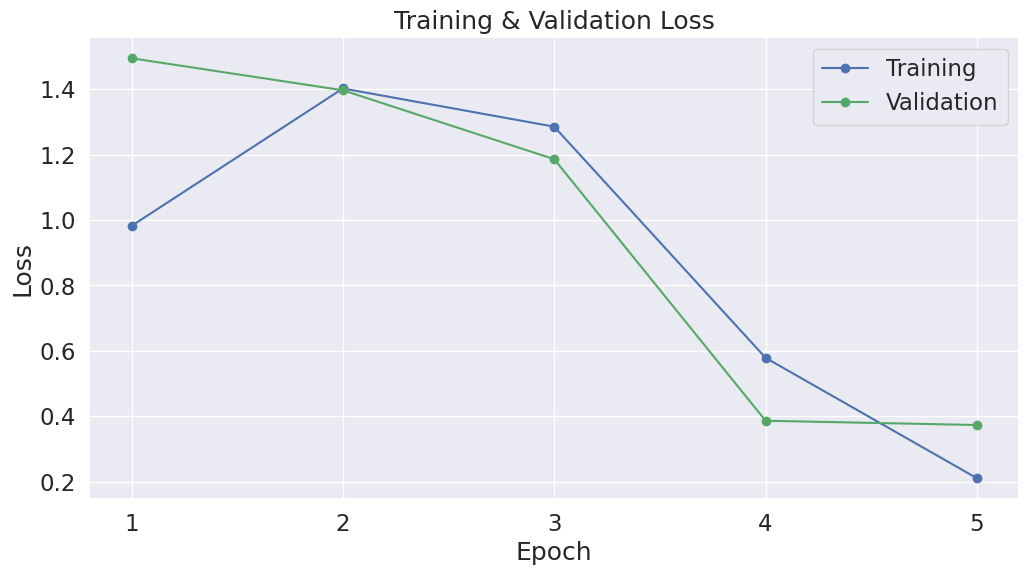

In [ ]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])
plt.show()

# Saving & Loading Fine-Tuned Model


In [ ]:
output_dir = './model_save/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print("Saving model to %s" % output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [ ]:
!ls -l --block-size=K ./model_save/

total 1387516K
-rw-r--r-- 1 root root       1K Jul 16 18:15 added_tokens.json
-rw-r--r-- 1 root root       1K Jul 16 18:15 config.json
-rw-r--r-- 1 root root       1K Jul 16 18:15 generation_config.json
-rw-r--r-- 1 root root     446K Jul 16 18:15 merges.txt
-rw-r--r-- 1 root root 1386066K Jul 16 18:15 model.safetensors
-rw-r--r-- 1 root root       1K Jul 16 18:15 special_tokens_map.json
-rw-r--r-- 1 root root       1K Jul 16 18:15 tokenizer_config.json
-rw-r--r-- 1 root root     976K Jul 16 18:15 vocab.json


In [ ]:
!ls -l --block-size=M ./model_save/model.safetensors

-rw-r--r-- 1 root root 1354M Jul 16 18:15 ./model_save/model.safetensors


In [ ]:
!cp -r ./model_save/ $data_dir

# Generate Text

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0:  Planning a luxury cruise to the Mediterranean is a sophisticated and indulgent travel experience that requires attention to detail and expert coordination. I can assist you in booking overwater bungalow accommodations at exclusive locations, arranging exclusive shore excursions, and curating personalized itinerary that showcase the beauty and culture of the Mediterranean region. Additionally, I can help arrange private dining experiences such as wine tastings in Tuscany, gourmet restaurants in Rome, or private tours of historical sites in Athens that showcase the region's culinary delights and traditions. By combining luxury amenities, personalized service, and immersive experiences, we can create a memorable and exquisite cruise experience that indulges your senses and leaves you with lasting memories of a truly extraordinary travel experience in the Mediterranean.


1:  Planning a multi-destination trip across Europe involves coordinating flight

# Chatbot

In [ ]:
!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 kB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 112.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 1

This code sets up an interactive chatbot interface using Gradio, powered by a pretrained GPT-2 model fine-tuned on tourism-related data. Users can input questions about booking trips or travel tips, and the chatbot will generate responses based on the input using the loaded model and tokenizer.

In [ ]:
import gradio as gr
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load your pretrained model and tokenizer
output_dir = "/content/gdrive/MyDrive/GPT2/model_save"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

# Function to generate response based on input text
def generate_response(input_text, history):
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)

    # Generate response
    sample_output = model.generate(
        input_ids,
        top_k=100,
        max_length=176,  # Adjust max_length as needed
        top_p=0.7,
        num_return_sequences=1
    )

    # Decode the generated response
    response = tokenizer.decode(sample_output[0], skip_special_tokens=True)

    # Remove the input text from the response if it appears
    if input_text in response:
        response = response.replace(input_text, "").strip()

    return response

# Create a Gradio interface
iface = gr.ChatInterface(
    fn=generate_response,
    chatbot=gr.Chatbot(height=400),
    textbox=gr.Textbox(placeholder="Enter your message here...", label="Input Message"),

    title="TourGPTv3 Chatbot",
    description="Ask questions about booking trips or travel tips!",
    examples=[
        ["What are the must-visit attractions in Rome?"],
        ["Where can I find the best seafood restaurants in Barcelona?"],
        ["What are the must-see attractions in Tokyo for first-time visitors?"],
        ["Can you provide me with information about popular tourist attractions in Paris?"],
        ["What is the best time of year to visit Bali, and what kind of weather should I expect?"],
        ["What are some travel tips for Europe?"],
        ["What is the best way to travel from Heathrow Airport to central London?"],
        ["What is your cancellation policy for a reservation at your hotel?"],
    ],
)

# Launch the interface
iface.launch()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://380f1e03ae7610037b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
